# TripAdvisor Restaurant Data Scraping Notebook

## Introduction

This notebook contains code for scraping restaurant data from the TripAdvisor website. It utilizes libraries such as `requests-html`, `BeautifulSoup`, and `pandas` to extract information about cities with restaurants, individual restaurants, and their corresponding details. The notebook is divided into three parts.

## First Part

The first part sets up the necessary libraries and functions. It includes the following steps:

- Imports the required libraries and modules.
- Defines functions for retrieving data from HTML pages and extracting city information.
- Starts an HTML session and sets the initial URL.
- Retrieves the city information from the first page and subsequent paginated pages.
- Stores the city information in a DataFrame and exports it to a CSV file.

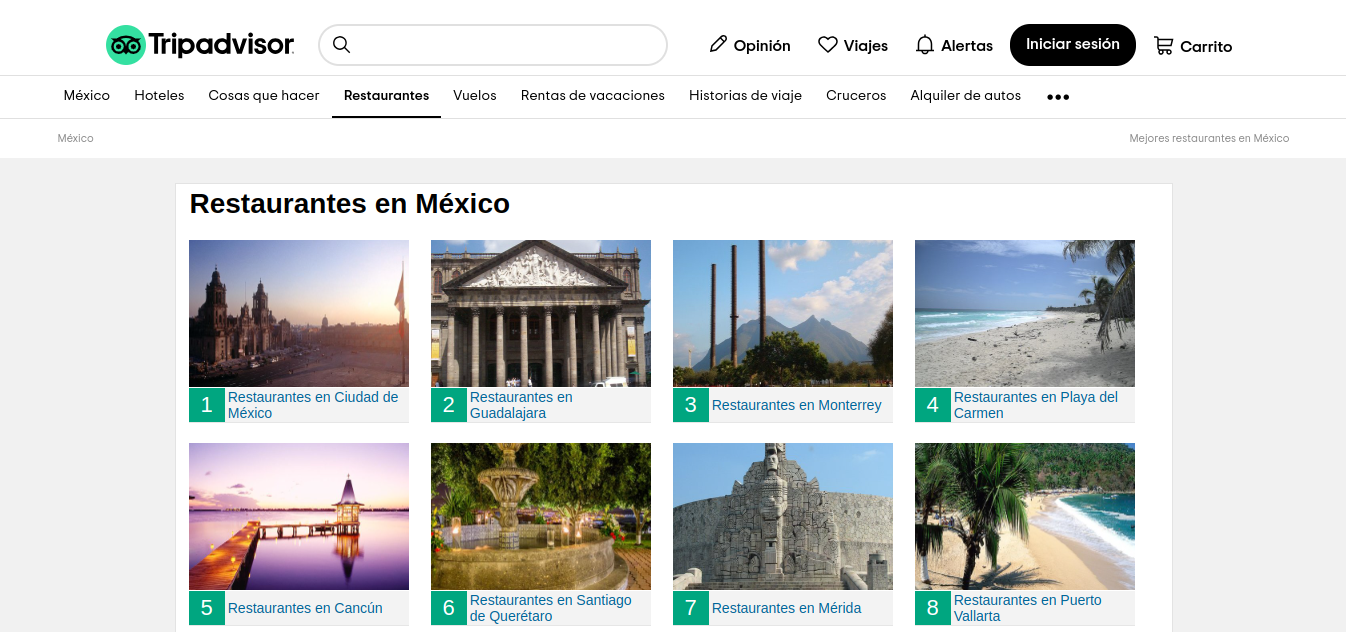

## Second Part

The second part focuses on extracting restaurant information for a specific city (in this case, Mexico City). The steps involved are as follows:

- Retrieves the URL of the Mexico City restaurants page from the city catalog DataFrame.
- Gets the HTML content of the page.
- Defines a function for extracting restaurant information from the page.
- Iterates over multiple pages to extract restaurant information using pagination.
- Stores the restaurant information in a DataFrame and exports it to a CSV file.

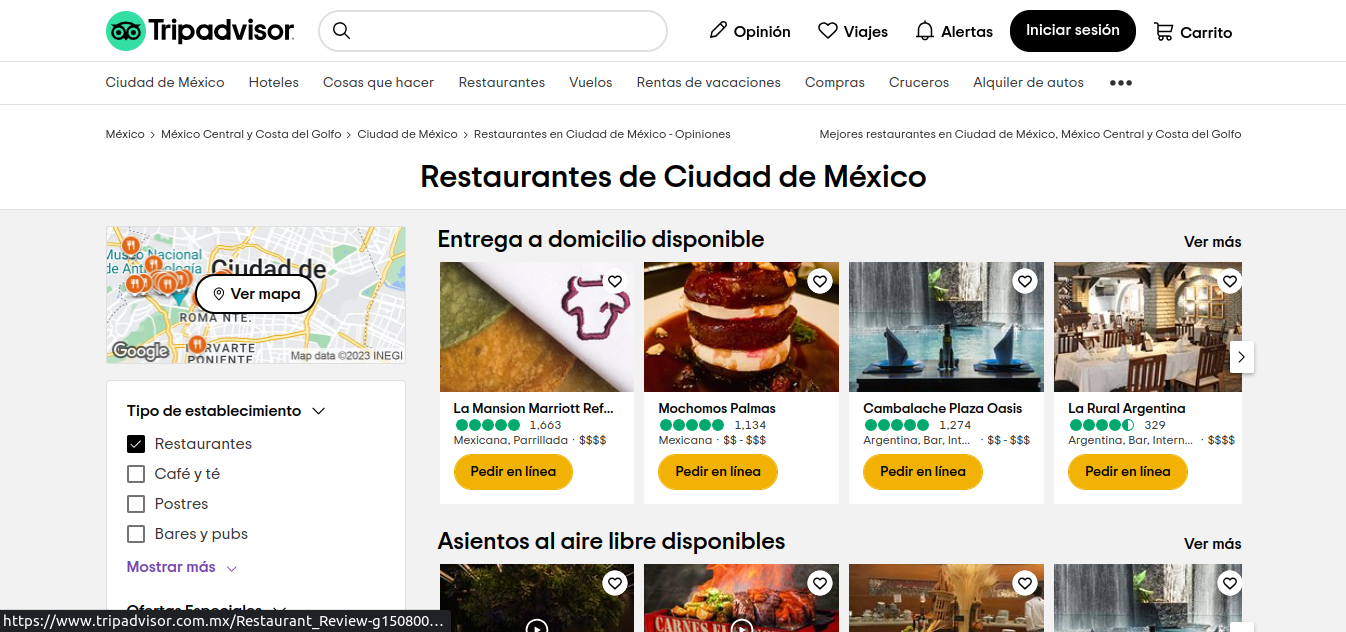

## Third Part: Restaurant Page Information

The third part focuses on extracting detailed information from individual restaurant pages. The steps involved are as follows:

- Defines a function to extract restaurant information from a specific page, given the name and popularity of the restaurant.
- Extracts information such as ratings, number of reviews, phone number, website, location, type of food, and other rating features.
- Stores the complete restaurant information in a DataFrame.
- Exports the restaurant information to a CSV file.

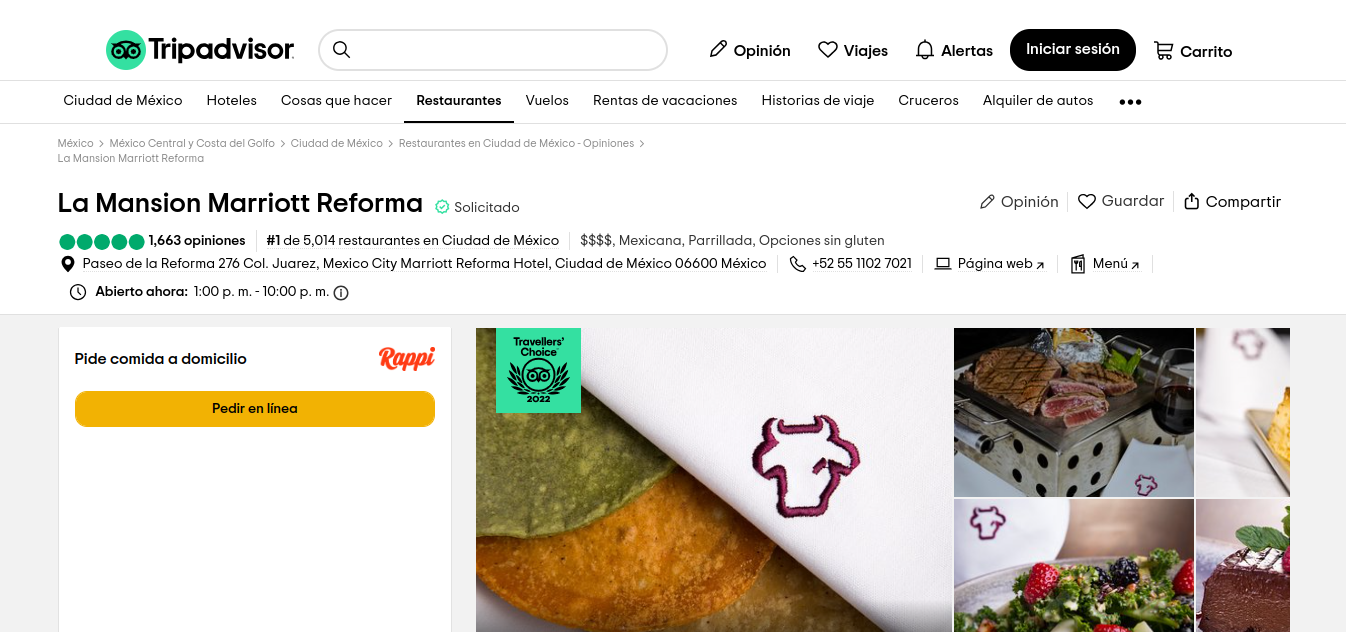

## Results

The notebook provides detailed explanations of each function and step, along with example outputs, allowing for a better understanding of the data extraction process.

In [1]:
#import libreries
!sudo pip install requests-html  nums_from_string
from requests_html import HTMLSession
from bs4 import BeautifulSoup, Tag
import pandas as pd
import re
import nums_from_string
import base64
import time

## First Part


In [2]:
#start session
s=HTMLSession()
initial_url='https://www.tripadvisor.com.mx'

In [3]:
def get_data(url:str):
  '''Function to get data from a html page

  Parameters:
  ----------
  url : str
      URL of the page to extract data
  -------

  This function return a BeautifulSoup conection
  '''
  r=s.get(url=url)
  soup=BeautifulSoup(r.content,'html.parser')
  return soup

In [4]:
def get_newpage(soup,i:int):
  '''Function to get the link to the new page from pagination

  Parameters:
  ----------
  soup : BeautifulSoup()
      Connection of the page from which the pagination is obtained

  i : Number of page to get
  -------

  This function returns link to the new page
  '''

  page=soup.find('a', attrs={'data-page-number':str(i)}).get('href')
  return page

In [5]:
def get_cities_list(soup, cities_catalog):
  '''Function to get the cities information in  the page

  Parameters:
  ----------
  soup : BeautifulSoup()
      Connection of the page
  -------

  This function reurn a list with dictionaries with information of each city with restaurants
  '''

  cities=soup.find('ul', class_='geoList')
  cities2=cities.find_all('li')


  for j,element in enumerate(cities2):

              name=element.find('a').text[16:]
              link=initial_url+element.find('a').get('href')

              cities_info={
              'popularity':page+j+1,
              'name':name,
              'url':link
              }
              cities_catalog.append(cities_info)

In [6]:
url='https://www.tripadvisor.com.mx/Restaurants-g150768-oa00-Mexico.html#LOCATION_LIST'
soup=get_data(url)
cities=soup.find_all('div', class_='geo_entry')

#first page
cities_catalog=[]
for i,element in enumerate(cities):
  name=element.find('div', class_='geo_name').text[17:-1]
  link=initial_url+element.find('a').get('href')
  cities_info={
      'popularity':i+1,
      'name':name,
      'url':link
  }
  cities_catalog.append(cities_info)

In [7]:
url='https://www.tripadvisor.com.mx/Restaurants-g150768-oa20-Mexico.html#LOCATION_LIST'
soup=get_data(url)
#cities_catalog=[]

#obtain the information of all the cities on the website
i=1
while True:

  page=20*i
  url='https://www.tripadvisor.com.mx/Restaurants-g150768-oa'+str(page)+'-Mexico.html#LOCATION_LIST'
  soup=get_data(url)

  try:
    get_cities_list(soup, cities_catalog)
  except AttributeError:
    break

  i+=1

## Results - First Part

In [8]:
print(f'There are {len(cities_catalog)} cities with restaurants on the website')

There are 1097 cities with restaurants on the website


In [9]:
#example of city information
cities_catalog[0]

{'popularity': 1,
 'name': 'Ciudad de México',
 'url': 'https://www.tripadvisor.com.mx/Restaurants-g150800-Mexico_City_Central_Mexico_and_Gulf_Coast.html'}

Save the catalog to a CSV and DataFrame file to keep working:

In [10]:
df_cities_catalog=pd.DataFrame(cities_catalog)
df_cities_catalog.to_csv('/tmp/cities_catalog.csv')

In [11]:
df_cities_catalog

,popularity,name,url
0,1,Ciudad de México,https://www.tripadvisor.com.mx/Restaurants-g15...
1,2,Guadalajara,https://www.tripadvisor.com.mx/Restaurants-g15...
2,3,Monterrey,https://www.tripadvisor.com.mx/Restaurants-g15...
3,4,Playa del Carmen,https://www.tripadvisor.com.mx/Restaurants-g15...
4,5,Cancún,https://www.tripadvisor.com.mx/Restaurants-g15...
...,...,...,...
1092,1093,Atotonilco,https://www.tripadvisor.com.mx/Restaurants-g16...
1093,1094,Zinacantán,https://www.tripadvisor.com.mx/Restaurants-g10...
1094,1095,Municipio de Vista Hermosa,https://www.tripadvisor.com.mx/Restaurants-g14...
1095,1096,Purépero,https://www.tripadvisor.com.mx/Restaurants-g31...


## Second Part

In [12]:
#Mexico City restaurants page
df_cities_catalog.url[0]
city=df_cities_catalog.name[0]

In [13]:
def get_restaurants(soup,restaurant_directory):
  '''Function to get the restaurants webside information in the page

  Parameters:
  ----------
  soup : BeautifulSoup()
      Connection of the page

  restaurant_directory: list
      List in wich data is stored
  -------

  This function reurn a list with dictionaries with information of restaurant webside
  '''
  restaurants=soup.find_all('div', attrs={'class': 'RfBGI'})[1:]

  for restaurant in restaurants:

              information=restaurant.find('a')
              non_sponsored=re.search(r'\d+', information.text)

              if non_sponsored:
                popularity=nums_from_string.get_nums(information.text)[0]
                name=re.findall(r'[a-zA-Z].*',information.text)[0]
                link=initial_url+information.get('href')

                restaurant_info={
                  'popularity':popularity,
                  'name':name,
                  'url':link
                }
                restaurant_directory.append(restaurant_info)




In [16]:
url=df_cities_catalog.url[0] #Mexico City restaurants page
page=get_data(url)
restaurant_directory=[]

#restaurant information is saved from pagination
i=2
while True:
  page=get_data(url)
  get_restaurants(page, restaurant_directory)

  try:
    new_page=get_newpage(page,i)
  except AttributeError:
    break
  url=initial_url+new_page
  i+=1

## Results - Second Part

In [17]:
print(f'There are {len(restaurant_directory)} restaurants in {city}')

There are 7352 restaurants in Ciudad de México


In [18]:
#example of restaurant directory information
restaurant_directory[0]

{'popularity': 1,
 'name': 'La Mansion Marriott Reforma',
 'url': 'https://www.tripadvisor.com.mx/Restaurant_Review-g150800-d2394477-Reviews-La_Mansion_Marriott_Reforma_Steakhouse-Mexico_City_Central_Mexico_and_Gulf_Coast.html'}

Save the catalog to a CSV and DataFrame file to keep working:

In [19]:
df_restaurant_directory=pd.DataFrame(restaurant_directory)
df_restaurant_directory.to_csv('/tmp/restaurant_directory.csv')

## Thirt part: Restaurant page information

In [20]:
def get_restaurant_information(soup, name, popularity, restaurant_dir):
  '''Function to get the restaurant information

  Parameters:
  ----------
  soup : BeautifulSoup()
      Connection of the page

  name : str
      Name of restaurant from restaurant directory

  popularity : str
      Popularity of restaurant from restaurant directory
  -------

  This function append a dictionary with information of the restaurant to a list
  '''

  try: #calification
    cal=float(soup.find('span', attrs={'class':'ZDEqb'}).text)
  except AttributeError:
    cal=None

  try: #number of reviews
    num_op=nums_from_string.get_nums(soup.find('span', attrs={'class':'reviews_header_count'}).text)[0]
  except AttributeError:
    num_op=None


  restaurant_inf={
      'Popularity':popularity,
      'Name':name,
      'Calfication':cal,
      'Num_reviwes':num_op
  }

  try: #phone
    phone=soup.find('a', attrs={'class':'BMQDV _F G- wSSLS SwZTJ','href': re.compile(r'tel.*')}).text
    restaurant_inf['Phone']=phone
  except AttributeError:
    pass

  try: #webside
    web=soup.find('a', attrs={'class':'YnKZo Ci Wc _S C AYHFM'}).get('data-encoded-url')
    web=(base64.b64decode(web))
    web=re.findall(r'http.+\_',str(web))[0][:-1]
    restaurant_inf['Webside']=web
  except (IndexError, AttributeError):
    pass

  try: #location
    loc=soup.find('a', attrs={'class':'YnKZo Ci Wc _S C FPPgD'}).get('data-encoded-url')
    loc=re.findall(r'\d+.\d+,.\d+.\d+',str(base64.b64decode(loc)))[0]
    loc=re.findall(r'.\d+.\d+', loc)

    lat=nums_from_string.get_nums(loc[0])[0]
    lng=nums_from_string.get_nums(loc[1])[0]

    restaurant_inf['Latitude']=lat
    restaurant_inf['Longitude']=lng

  except IndexError:
    pass

  try: #type of food
    food=soup.find('div', attrs={'class':'tbUiL b'}, text='TIPOS DE COMIDA')
    type_food=food.find_next().text
    restaurant_inf['Type_food']=type_food
  except AttributeError:
    pass

  califications=soup.find_all('div', attrs={'class':'DzMcu'})

  for i in (califications): #calification features
    xd=i.find('span', class_='vzATR').find('span').get('class')[1]
    number=int(re.findall(r'\d+', xd)[0])/10
    restaurant_inf[i.text]=number


  restaurant_dir.append(restaurant_inf)

Get information of all restaurant in restaurant directory

In [21]:
restaurant_dir=[]

In [ ]:
for i in range(len(restaurant_dir),len(df_restaurant_directory)):

  popularity=df_restaurant_directory.popularity[i]
  url=df_restaurant_directory.url[i]
  name=df_restaurant_directory.name[i]

  try:
    soup=get_data(url)
  except s.exceptions.ChunkedEncodingError:
    time.sleep(1)

  get_restaurant_information(soup, name, popularity,restaurant_dir)


## Results - Thirt Part

In [24]:
print(f'There is information from {len(restaurant_dir)} restaurants')

There is information from 7352 restaurants


In [25]:
df_restaurant_information=pd.DataFrame(restaurant_dir)
df_restaurant_information.to_csv('/tmp/restaurant_information.csv')

In [28]:
df_restaurant_information

,Popularity,Name,Calfication,Num_reviwes,Webside,Latitude,Longitude,Type_food,Comida,Servicio,Calidad/precio,Ambiente
0,1,La Mansion Marriott Reforma,5.0,1663.0,http://www.facebook.com/mansionmarriottreforma,19.428345,-99.164260,"Mexicana, Parrillada",4.5,4.5,4.5,4.0
1,2,Balta,5.0,1363.0,http://www.sofitel-mexico-city.com/restaurants...,19.428432,-99.165920,"Mexicana, Mediterránea, Mariscos, Parrilla",5.0,5.0,5.0,NaN
2,3,KYU MÉXICO,5.0,809.0,http://www.kyumexico.com,19.431955,-99.200890,"Tailandesa, Asiática, Coreana, Fusión",5.0,5.0,4.5,NaN
3,4,Parole Polanco,5.0,3484.0,https://parole.mx/en/italian-restaurant-in-cdmx,19.430412,-99.199400,"Italiana, Contemporánea, Toscana, Del centro i...",5.0,5.0,4.5,NaN
4,5,Animal,5.0,1591.0,http://costeno.com/animal,19.432081,-99.199290,"Mexicana, Pub, Fusión, Gastropub, Española",5.0,5.0,4.5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
7347,7349,Santa #cocinacoqueta,NaN,NaN,NaN,19.420197,-99.174260,"Mexicana, Saludable",NaN,NaN,NaN,NaN
7348,7350,La Trinchera México,NaN,NaN,http://latrincheramexico.com,19.380705,-99.165825,Mexicana,NaN,NaN,NaN,NaN
7349,7351,La Strada,NaN,NaN,http://www.lastradadf.com,19.390265,-99.043290,Italiana,NaN,NaN,NaN,NaN
7350,7352,BP,NaN,NaN,https://www.bp.com/es_mx/mexico/home.html,19.337640,-99.119210,NaN,NaN,NaN,NaN,NaN
